Se analizaran los datos de Grupo Financiero Inbursa, desde el 7-02-2001 hasta 4-02-2021

In [1]:
import torch, pywt, csv, numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import src.utilerias.reader as rd
import src.utilerias.utilerias as utls
import src.utilerias.seniales.dwt.dwt_multinivel as m_dwt
# Llamamos a la función antes de ejecutar el script
utls.eliminar_archivos_registro("logs/auto_regresivo")

/home/miguel/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-02-04 02:06:59.589265: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 02:06:59.909035: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 02:06:59.909093: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 02:06:59.910466: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

In [2]:
from src.modelos.DWT_Auto_regresivo.entrenamiento.entrenamientos import Entrenamiento as entr
from src.modelos.DWT_Auto_regresivo.NARNN import NARNN
criterion = nn.MSELoss()
redes = {"red_A1" : 'models/red_A1.pth',
         "red_D1" : 'models/red_D1.pth',
         "red_D2" : 'models/red_D2.pth',
         "red_D3" : 'models/red_D3.pth',
         "red_D4" : 'models/red_D4.pth',
         "red_D5" : 'models/red_D5.pth'}

Longitud de la entrada: 260


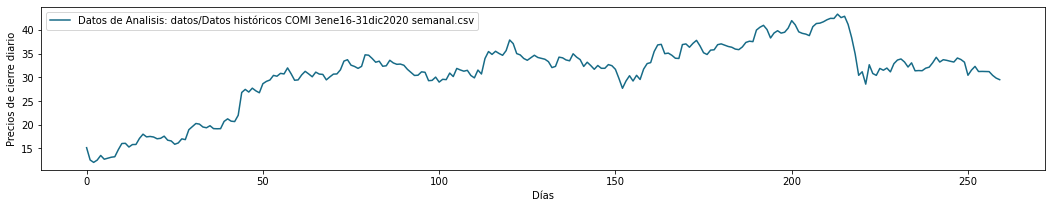

In [3]:
# Abrir el archivo CSV en modo lectura

# DATOS = 'cierre.csv'#Grupo Financiero Inbursa
# DATOS = 'Datos históricos COMI 03012016_27122020.csv' #Datos originales
DATOS = 'datos/Datos históricos COMI 3ene16-31dic2020 semanal.csv' #Datos semanales
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020.csv' #Datos semanales de prueba
# DATOS = 'Datos históricos COMI3ene2016_27dic2020_diario.csv' #Datos originales diarios de prueba
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020_DIARIO.csv' #Datos diarios de prueba

cierre = rd.leer_archivo(DATOS)
#se convierten todos los valores a flotantes
cierre = cierre.astype(float)

# Crear un gráfico de línea con los valores de x, y
print(f"Longitud de la entrada: {len(cierre)}")
plt.figure(figsize=(18, 3))
plt.plot(range(len(cierre)), cierre, label=f"Datos de Analisis: {DATOS}", color='#176B87')
plt.xlabel('Días')
plt.ylabel('Precios de cierre diario')
plt.legend()
plt.show()

# Eleccion de Mother Wavelet

Se elige las mother wavelets dependiendo de las caracteristicas de la serie de tiempo que se va a analizar. Para series que impliquen cambios no smoothos y repentinos es recomendable usar Haar ya que responde bien a estos cambios repentinos.

Se elige bior3.5 debido a las caracteristicas de las fluctuaciones entre periodos con altas cantidades de inversiones y periodos en los que no.

En general, el mother wavelet debe de ser una funcion de las caracteristicas de la serie original para que esta pueda ser reconstruida o analizada 

Longitud de la entrada de cA: 135


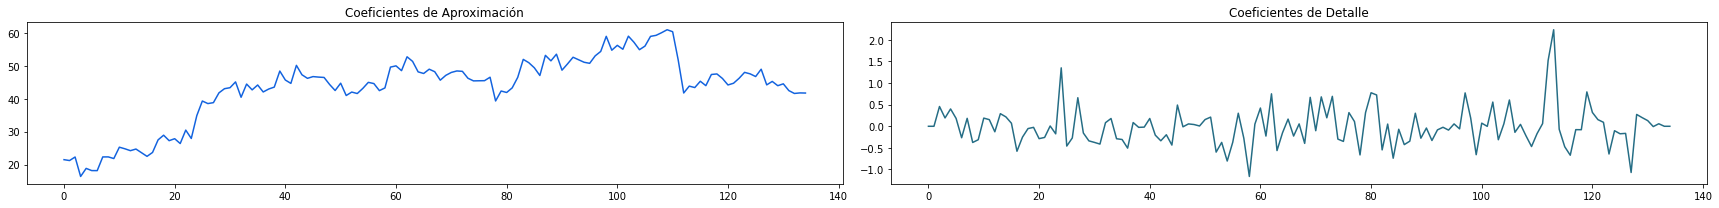

In [4]:
#Se descompone la lista de precios de cierre del intervalo mencionado anteriormente a partir de la dwt con la función bior3.5
# print(pywt.wavelist()) imprime la lista de wavelets de la biblioteca
wavelet = 'bior3.5'
mode = pywt.Modes.constant #antireflect, smooth
wavelet = pywt.Wavelet(wavelet)
(cA, cD) = pywt.dwt(cierre.tolist(), wavelet, mode=mode)
print(f"Longitud de la entrada de cA: {len(cA)}")

plt.figure(figsize=(24, 3))
aprox_coef = True
index = 1

for _ in [cA, cD]:
    plt.subplot(1, 2, index)
    plt.plot(range(len(_)), _, color='#1363DF' if aprox_coef else '#256D85')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    index = index + 1

plt.tight_layout()
plt.show()

1. Divide the weekly closing stock prices into a training dataset (70%) and a testing dataset (30%). 
Se realiza la separacion del conjunto de entrenamiento y el de prueba
<img src="/imagenes/DWT-NARNN_step1.png" alt="Descripción de la imagen">

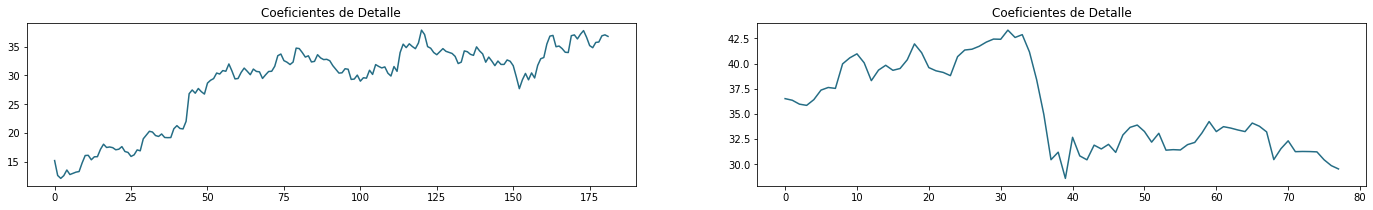

In [5]:
#Se realiza el proceso 5 veces
cierre_e = cierre[:int(len(cierre) * 0.7)]#cierre entrenamiento len 182
cierre_p = cierre[int(len(cierre) * 0.7):]#cierre prueba len 78

plt.figure(figsize=(24, 3))
index = 1

for _ in [cierre_e, cierre_p]:
    plt.subplot(1, 2, index)
    plt.plot(range(len(_)), _, color='#1363DF' if aprox_coef else '#256D85')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    index = index + 1

Decompose the training dataset by the DWT, 
utilizing the biorthogonal 3.5 mother wavelet, into 
approximation coefficients A(t) and detail coefficients D(t), as 
discussed  in  section  2.1.  Set  the  decomposition  level  to  five 
[12] and extract six components D1, D2, D3, D4, D5, and A5.

In [6]:
# #mode = pywt.Modes.constant
# mode = 'reflect'
# # coeffs = pywt.wavedec(cierre, wavelet, level=5, mode=mode)
# # coeffs_e = pywt.wavedec(cierre_e, wavelet, level=5, mode=mode)
# # components_p = pywt.wavedec(cierre_p, wavelet, level=5,mode=mode)
# components = m_dwt.multilevel_dwt(cierre, wavelet, 5, mode)
# components_e = m_dwt.multilevel_dwt(cierre_e, wavelet, 5, mode)
# components_p = m_dwt.multilevel_dwt(cierre_p, wavelet, 5, mode)

# # coeffs_rec = []
# # coeffs_rec.append(pywt.upcoef('a', coeffs[0], wavelet, level = 5, take=len(cierre)))#, take=len(cierre)))
# # coeffs_rec.append(pywt.upcoef('d', coeffs[1], wavelet, level = 5, take=len(cierre)))#, take=len(cierre)))
# # coeffs_rec.append(pywt.upcoef('d', coeffs[2], wavelet, level = 4, take=len(cierre)))#, take=len(cierre)))
# # coeffs_rec.append(pywt.upcoef('d', coeffs[3], wavelet, level = 3, take=len(cierre)))#, take=len(cierre)))
# # coeffs_rec.append(pywt.upcoef('d', coeffs[4], wavelet, level = 2, take=len(cierre)))#, take=len(cierre)))
# # coeffs_rec.append(pywt.upcoef('d', coeffs[5], wavelet, level = 1, take=len(cierre)))#, take=len(cierre)))

# N = len(cierre_p)
# print(N)
# #print(pywt.upcoef('a', components_p[0], wavelet, level = 5))
# # components_p_rec = []
# # components_p_rec.append(pywt.upcoef('a', components_p[0], wavelet, level = 5))#, take = 98
# # components_p_rec.append(pywt.upcoef('d', components_p[1], wavelet, level = 5))
# # components_p_rec.append(pywt.upcoef('d', components_p[2], wavelet, level = 4))
# # components_p_rec.append(pywt.upcoef('d', components_p[3], wavelet, level = 3))
# # components_p_rec.append(pywt.upcoef('d', components_p[4], wavelet, level = 2))
# # components_p_rec.append(pywt.upcoef('d', components_p[5], wavelet, level = 1))
# #print(len(cierre_p))

# for uc in components_p:
#     print(len(uc))
#     #print(uc)

# # cA_5 = components_p[0]
# # cD_5 = components_p[1]
# # cD_4 = components_p[2]
# # cD_3 = components_p[3]
# # cD_2 = components_p[4]
# # cD_1 = components_p[5]
# print(f"Longitud de la entrada de A_5: {len(components_p[0])}")

# plt.figure(figsize=(32, 8))
# aprox_coef = True
# index = 1

# for _ in components_p:
#     plt.subplot(2, 3, index)
#     plt.plot(range(len(_)), _, color='#DA0C81' if aprox_coef else '#610C9F')
#     plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
#     aprox_coef = False
#     index = index + 1

# plt.tight_layout()
# plt.show()

# o_data = 0
# components_p.reverse()
# for c in components_p:
#     o_data =  o_data + c

# plt.plot(range(len(o_data)),o_data)
# plt.show()


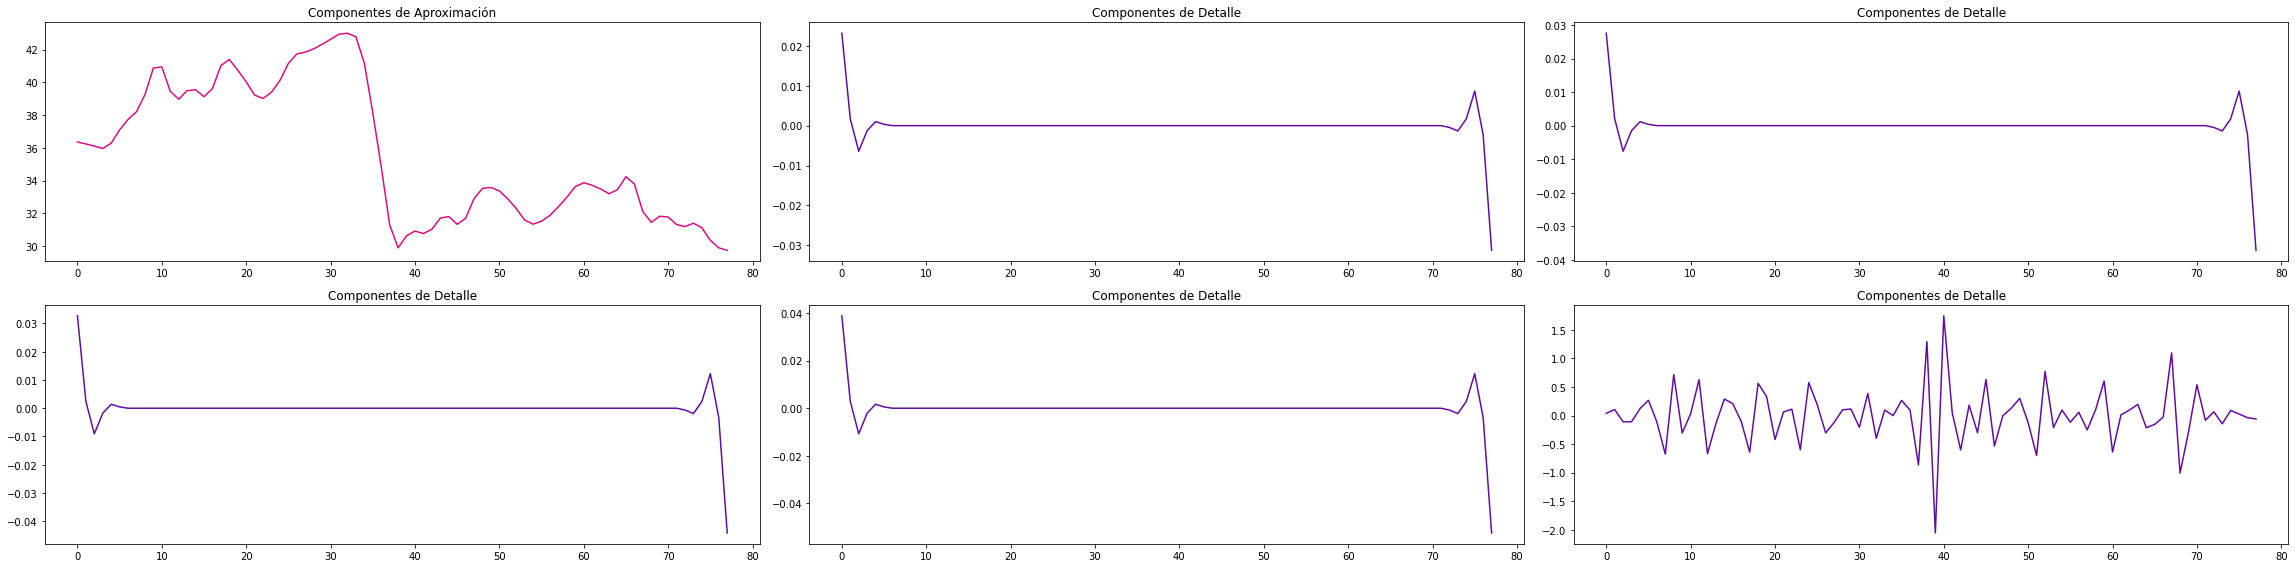

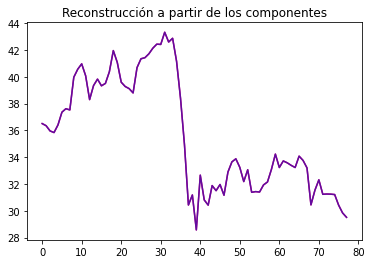

In [7]:
mode = 'constant'
components = m_dwt.multilevel_dwt(cierre, wavelet, 5, mode) #componentes de la serie completa
components_e = m_dwt.multilevel_dwt(cierre_e, wavelet, 5, mode) # componentes de entrenamiento 
components_p = m_dwt.multilevel_dwt(cierre_p, wavelet, 5, mode) #componentes de prueba
# N = len(cierre_p)
# print(f"Longitud de la entrada de A_5: {len(components_p[0])}")

plt.figure(figsize=(32, 8))
aprox_coef = True
index = 1

for _ in components_p:
    plt.subplot(2, 3, index)
    plt.plot(range(len(_)), _, color='#DA0C81' if aprox_coef else '#610C9F')
    plt.title('Componentes de Aproximación' if aprox_coef else 'Componentes de Detalle')
    aprox_coef = False
    index = index + 1

plt.tight_layout()
plt.show()

o_data = 0 #original data
for c in components_p:
    o_data =  o_data + c

plt.plot(range(len(o_data)),o_data, color='#DA0C81')
plt.plot(range(len(cierre_p)),o_data, color='#610C9F')
plt.title('Reconstrucción a partir de los componentes')
plt.show()

In [8]:
# coeffs_p_rec_dec = []
# components_p_rec_dec.append(pywt.downcoef('a',components_p_rec[0], wavelet, mode=mode,level=5))
# coeffs_p_rec_dec.append(pywt.downcoef('d',coeffs_p_rec[1], wavelet, mode=mode,level=5))
# coeffs_p_rec_dec.append(pywt.downcoef('d',coeffs_p_rec[2], wavelet, mode=mode,level=4))
# coeffs_p_rec_dec.append(pywt.downcoef('d',coeffs_p_rec[3], wavelet, mode=mode,level=3))
# coeffs_p_rec_dec.append(pywt.downcoef('d',coeffs_p_rec[4], wavelet, mode=mode,level=2))
# coeffs_p_rec_dec.append(pywt.downcoef('d',coeffs_p_rec[5], wavelet, mode=mode,level=1))

# plt.figure(figsize=(32, 8))
# aprox_coef = True
# index = 1

# for _ in coeffs_p_rec_dec:
#     plt.subplot(2, 3, index)
#     plt.plot(range(len(_)), _, color='#DA0C81' if aprox_coef else '#610C9F')
#     plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
#     aprox_coef = False
#     index = index + 1

# plt.tight_layout()
# plt.show()

In [9]:
# def take(rec, take=0):
#     rec_len = len(rec)
#     if take > 0 and take < rec_len:
#         left_bound = right_bound = (rec_len-take) // 2
#         if (rec_len-take) % 2:
#             # right_bound must never be zero for indexing to work
#             right_bound = right_bound + 1

#         return rec[left_bound:-right_bound]
    
# #print(take([0,1,2,3,4,5,6,7,8,9],take = 2))

# A4 = pywt.upcoef('a', coeffs_p[0], wavelet, level = 5, take = 390) + pywt.upcoef('d', coeffs_p[1], wavelet, level = 5, take = 390)
# A3 = take(A4, take = 222) + pywt.upcoef('d', coeffs_p[2], wavelet, level = 4, take = 222)
# A2 = take(A3, take = 138) + pywt.upcoef('d', coeffs_p[3], wavelet, level = 3, take = 138)
# A1 = take(A2, take = 98) + pywt.upcoef('d', coeffs_p[4], wavelet, level = 2, take = 98)
# c_final = take(A1, take = 78) + pywt.upcoef('d', coeffs_p[5], wavelet, level = 1, take = 78)
# #c_final = coeffs_p_rec[0]+ coeffs_p_rec[1] + coeffs_p_rec[2] + coeffs_p_rec[3] + coeffs_p_rec[4] + coeffs_p_rec[5]
# print(c_final)
# plt.figure(figsize=(32, 8))
# aprox_coef = True
# index = 1


# plt.plot(range(len(c_final)), c_final, color='#DA0C81' if aprox_coef else '#610C9F')
# aprox_coef = False
# #plt.plot(range(len(cierre_p)), cierre_p, color='#DA0C81' if aprox_coef else '#610C9F')
# plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')

# index = index + 1

# plt.tight_layout()
# plt.show()

3. Normalize the decomposed components using the Min-Max normalization method.

In [10]:
#Se normalizan cada uno de los elementos de los vectores contenidos en las descomposicion de la serie de tiempo original
components_e_n = [utls.normalizar(vect) for vect in components_e] # componentes de entrenamiento normalizados
components_p_n = [utls.normalizar(vect) for vect in components_p] # componentes de prueba normalizados len 78

#Se concatenan los ultimo 8 elementos del conjunto de entrenamiento para predecir el primero del conjunto de prueba
for i in range(len(components_p_n)):
    components_p_n[i] = np.concatenate((components_e_n[i][-8:],components_p_n[i]))

#Estos 6 arreglos representan la descomposición de la señal original. Se tendrán que armar 6 redes que predigan cada una de estas
#componentes, Las entradas correspondientes a cada una son las 8 semanas anteriores para calcular la novena

#entrenamiento,prueba,validacion = utls.generar_conjuntos(coeffs_n,False,5)
#la de abajo es una prueba
#entrenamiento,prueba,validacion = utls.generar_conjuntos([[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10]],False,1)

4. Build  six  NARNNs,  with  the  topology  shown  in Figure 3, to forecast each decomposed component. The number of feedback delays in the TDL is set to eight, i.e., the preceding  eight  weeks'  closing  prices  are  utilized  to  forecast the ninth-week closing price.

In [11]:
red_A5 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
#red_A5.load_state_dict(torch.load('redes/DWT_Auto_regresivo/red_A5.pth'))
#red_A5.eval()

red_D5 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
# red_D1.load_state_dict(torch.load('models/red_D1_n.pth'))
# red_D1.eval()

red_D4 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
# red_D2.load_state_dict(torch.load('models/red_D2_n.pth'))
# red_D2.eval()

red_D3 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
# red_D3.load_state_dict(torch.load('models/red_D3_n1.pth'))
# red_D3.eval()

red_D2= NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
# red_D4.load_state_dict(torch.load('models/red_D4_n1.pth'))
# red_D4.eval()

red_D1 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
# red_D5.load_state_dict(torch.load(redes["red_D5"]))
# red_D5.eval()

networks = [red_A5,red_D5,red_D4,red_D3,red_D2,red_D1]

#entradas ya procesadas
entrenamiento_8_1 = [[],[],[],[],[],[]]
prueba_8_1 = [[],[],[],[],[],[]]
serie_c = [[],[],[],[],[],[]]
coeffs_n_prueba_8_1 = [[],[],[],[],[],[]]

# A cada uno de los conjuntos de entrenamiento se les da una forma de entrada en especifico,
# que es un arreglo de 8 y uno de un solo elemento para representar la salida
for e in range(6):
    # entrenamiento_8_1[e] = utls.corrimiento_t_1(entrenamiento[e],9)
    # prueba_8_1[e] = utls.corrimiento_t_1(prueba[e],9)
    # serie_c[e] = utls.corrimiento_t_1(coeffs_n[e],9)
    # coeffs_n_prueba_8_1[e] = utls.corrimiento_t_1(coeffs_n_prueba[e],9)

    entrenamiento_8_1[e] = utls.corrimiento_t_1(components_e_n[e],9)
    prueba_8_1[e] = utls.corrimiento_t_1(components_p_n[e],9)

5. Divide the training dataset into three parts: 70% for training, 15% for validation, and 15% as test data. Then train the six NARNNs

In [12]:
#Se define el número de epocas
EPOCAS = 3

In [13]:
entr_A5 = entr(networks[0])
entr_A5.entrena_lm(0,entrenamiento_8_1[0],EPOCAS,lr=0.5,λ=0.1,e_predictivo=False)
# torch.save(red_A5.state_dict(), 'models/red_A5_datos_originales.pth') #Salvamos el estado actual del modelo

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/home/miguel/anaconda3/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1949, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/home/miguel/anaconda3/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1984, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
entr.entrena_LM(networks[1],1,entrenamiento_8_1,EPOCAS,lr=0.01,λ =0.1)
torch.save(networks[1].state_dict(), 'redes/DWT_Auto_regresivo/red_D5.pth') 

entr.entrena_LM(networks[2],2,entrenamiento_8_1,EPOCAS,lr=0.01,λ =0.1)
torch.save(networks[2].state_dict(), 'redes/DWT_Auto_regresivo/red_D4.pth')

TypeError: entrena_LM() missing 1 required positional argument: 'batch_size'

In [ ]:
entr.entrena_LM(networks[3],3,entrenamiento_8_1,EPOCAS,lr=0.01,λ =0.1)
torch.save(networks[3].state_dict(), 'redes/DWT_Auto_regresivo/red_D3.pth') 

entr.entrena_LM(networks[4],4,entrenamiento_8_1,EPOCAS,lr=0.01,λ =0.1)
torch.save(networks[5].state_dict(), 'redes/DWT_Auto_regresivo/red_D2.pth')

In [ ]:
entr.entrena_LM(networks[5],5,entrenamiento_8_1,EPOCAS,lr=0.01,λ =0.1)
torch.save(networks[5].state_dict(), 'redes/DWT_Auto_regresivo/red_D1.pth')
#entradas ya procesadas
# entrenamiento_8_1 = [[],[],[],[],[],[]]

# A cada uno de los conjuntos de entrenamiento se les da una forma de entrada en especifico,
# que es un arreglo de 8 y uno de un solo elemento para representar la salida
# for e in range(6):
#     entrenamiento_8_1[e] = utls.corrimiento_t_1(entrenamiento[e],9)

#pruebas_ordenadas = []

# for e in range(6):
#     entrenamiento_8_1[e] = utls.corrimiento_t_1(entrenamiento[e],9)

#for c_pruebas in entrenamiento:#entre
    #print("corrimiento: " + str(utls.corrimiento_t_1(c_pruebas,9)))
 #   pruebas_ordenadas.append(utls.corrimiento_t_1(c_pruebas,9))#prueba[0] es el conjunto de prueba para cada red
#pruebas = forma_entrada(prueba[0],9)#prueba[0] es el conjunto de prueba para A1
#print(utls.genera_prediccion_1(pruebas_ordenadas[0],red_A1))
#print(len(utls.genera_prediccion(pruebas_ordenadas[0],red_A1).detach().numpy().tolist()[0]))
#print(entrenamiento[0])


# Predicción del conjunto de entrenamiento
usando los datos originales para la recurrencia

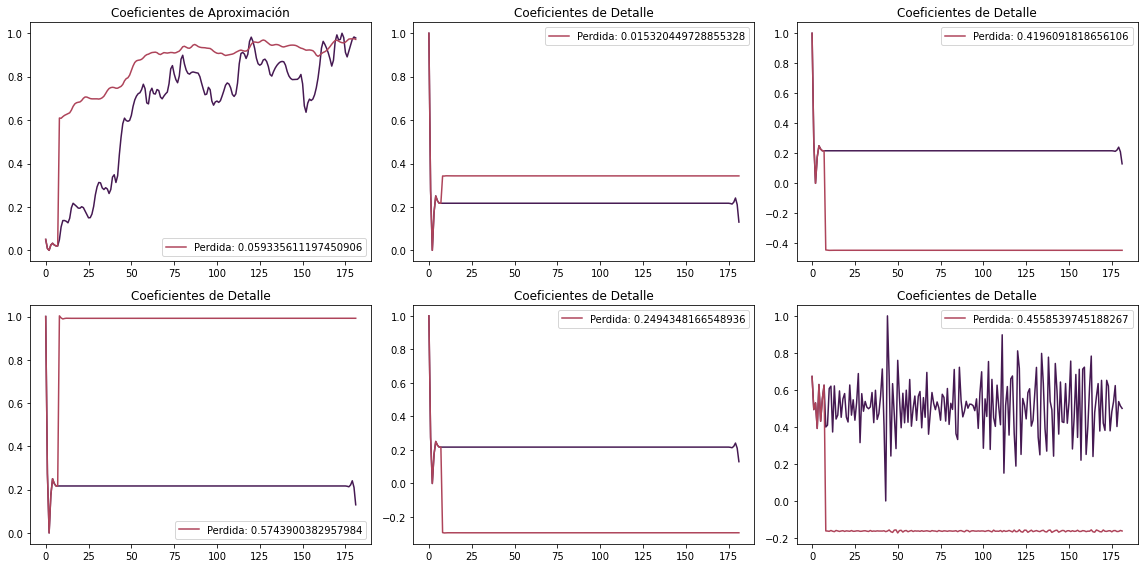

Perdidas: [tensor(0.0593, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0153, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.4196, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.5744, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.2494, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.4559, dtype=torch.float64, grad_fn=<MseLossBackward0>)]


In [14]:
#Se grafica el conjunto de entrenamiento
perdidas = []
plt.figure(figsize=(16, 8))

aprox_coef = True
index = 1

for _ in range(len(components_e_n)):
    prediccion = utls.genera_prediccion_1(entrenamiento_8_1[_],networks[_],8)
    perdidas.append(criterion(prediccion, torch.tensor(components_e_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(range(len(components_e_n[_])), components_e_n[_], color = '#451952') #color='#DA0C81' if aprox_coef else '#610C9F')
    plt.plot(range(len(components_e_n[_])), prediccion.detach().numpy(), label = f"Perdida: {float(perdidas[_])}", color='#AE445A')#label=f"Datos de Analisis: {DATOS}",
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()


print("Perdidas: " + str(perdidas))

# Predicción del conjunto de prueba
usando los datos originales para la recurrencia

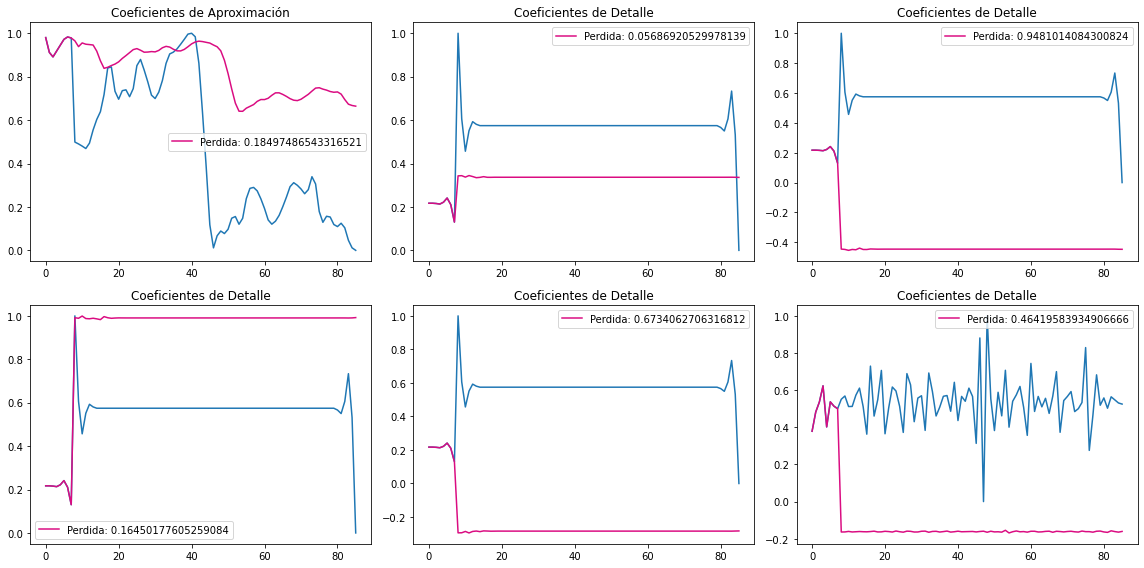

Perdidas: [tensor(0.1850, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0569, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.9481, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.1645, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.6734, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.4642, dtype=torch.float64, grad_fn=<MseLossBackward0>)]


In [15]:

perdidas = []
plt.figure(figsize=(16, 8))

aprox_coef = True
index = 1

for _ in range(len(components_p_n)):
    prediccion = utls.genera_prediccion_1(prueba_8_1[_],networks[_],8)
    perdidas.append(criterion(prediccion, torch.tensor(components_p_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(range(len(components_p_n[_])), components_p_n[_]) #color='#DA0C81' if aprox_coef else '#610C9F')
    plt.plot(range(len(components_p_n[_])), prediccion.detach().numpy(), label = f"Perdida: {float(perdidas[_])}" ,color='#DA0C81')#label=f"Datos de Analisis: {DATOS}",
    
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

print("Perdidas: " + str(perdidas))

#Se grafica el conjunto de pruebas
# plt.plot(range(len(prueba[0])), prueba[0])
# plt.plot(range(len(prueba[0])), utls.genera_prediccion_1(prueba_8_1[0],red_A1,8).detach().numpy())
# plt.show(

#plt.plot(range(108), entrenamiento[0][:-8])
#plt.plot(range(108), [utls.desnormalizar(vect) for vect in utls.genera_prediccion(pruebas_ordenadas[0],red_A1).detach().numpy().tolist()[0]])
# Mostrar el gráfico
#plt.show()
#investigar bien la dwt y predecir la red con los corrimientos de 1, usando los datos que predice o solo los datos que le doy
#Lo que hace es generar una prediccion cada noveno día, con los datos que ya se le dan del entrenamiento, es preciso ajustar los parametros hasta que ambas series
#sean iguales
#print(prueba[0])

# Generamos el entrenamiento predictivo

In [18]:
#entr.entrena_LM_pred(networks[0],0,entrenamiento_8_1,15 ,lr=0.5,λ =0.1,batch_size=8,decay_factor=5) #EPOCAS
#entr.cerrar_escritor()
entr_A5.entrena_lm(0,entrenamiento_8_1[0],12,lr=0.5,λ =0.1,batch_size=8,decay_factor=5,e_predictivo=True)

#torch.save(networks[0].state_dict(), 'redes/DWT_Auto_regresivo/red_A5_datos_originales_pred') #Salvamos el estado actual del modelo

# entr.entrena_LM_pred(red_D5,1,entrenamiento_8_1,EPOCAS)
# torch.save(red_D5.state_dict(), 'models/red_D5_datos_originales_pred.pth') 
#networks[0].load_state_dict(torch.load('redes/DWT_Auto_regresivo/red_A5_datos_originales_pred.pth'))
#networks[0].eval()

---INICIO DE ENTRENAMIENTO: entrena_LM---
---Inicio de epoca: 0--
Predicción pre entreno: tensor([0.2564], grad_fn=<ViewBackward0>)
Predicción pre entreno: tensor([0.2570], grad_fn=<ViewBackward0>)
Predicción pre entreno: tensor([0.2634], grad_fn=<ViewBackward0>)
Predicción pre entreno: tensor([0.2717], grad_fn=<ViewBackward0>)
Predicción pre entreno: tensor([0.2675], grad_fn=<ViewBackward0>)
Predicción pre entreno: tensor([0.2765], grad_fn=<ViewBackward0>)
Predicción pre entreno: tensor([0.2804], grad_fn=<ViewBackward0>)
Predicción pre entreno: tensor([0.3006], grad_fn=<ViewBackward0>)
subepocas: 1
>>Inicio de paso (Los valores de la perdida aqui contenidos solo son usados para calculos)
>>Fin de paso
>>Se calcula perdida despues del paso...
entrada: tensor([0.0503, 0.0086, 0.0000, 0.0245, 0.0327, 0.0246, 0.0205, 0.0203])
----->SALIDA DE LA RED OBTENIDA: tensor([0.1827], grad_fn=<ViewBackward0>)
----->SALIDA ESPERADA: tensor([0.0494])
entrada: tensor([0.0086, 0.0000, 0.0245, 0.0327, 0

In [ ]:
entr.entrena_LM_pred(networks[1],1,entrenamiento_8_1,15 ,lr=0.5,λ =0.1,batch_size=1,decay_factor=5)
#torch.save(networks[1].state_dict(), 'redes/DWT_Auto_regresivo/red_D5_pred')
# networks[1].load_state_dict(torch.load('redes/DWT_Auto_regresivo/red_D5_pred.pth'))
# networks[1].eval()

entr.entrena_LM_pred(networks[2],2,entrenamiento_8_1,15 ,lr=0.5,λ =0.1,batch_size=8,decay_factor=5)
#torch.save(networks[2].state_dict(), 'redes/DWT_Auto_regresivo/red_D4_pred')
# networks[2].load_state_dict(torch.load('redes/DWT_Auto_regresivo/red_D4_pred.pth'))
# networks[2].eval()

---INICIO DE ENTRENAMIENTO: entrena_LM_pred---
---Inicio de epoca: 1--
>>Salida: tensor([0.2170])
prediccion pre entreno: tensor([0.4985], grad_fn=<ViewBackward0>)
A comparar perdida actual: tensor([0.2170]) ,  tensor([0.4985])
Perdida actual: 0.0792631134390831
subepocas: 1


KeyboardInterrupt: 

In [ ]:
entr.entrena_LM_pred(networks[3],3,entrenamiento_8_1,15 ,lr=0.5,λ =0.1,batch_size=8,decay_factor=5)
torch.save(networks[3].state_dict(), 'redes/DWT_Auto_regresivo/red_D3_pred')
# networks[3].load_state_dict(torch.load('redes/DWT_Auto_regresivo/red_D3_datos_originales_pred.pth'))
# networks[3].eval()

entr.entrena_LM_pred(networks[4],4,entrenamiento_8_1,15 ,lr=0.5,λ =0.1,batch_size=8,decay_factor=5)
torch.save(networks[4].state_dict(), 'redes/DWT_Auto_regresivo/red_D2_pred')
# networks[4].load_state_dict(torch.load('redes/DWT_Auto_regresivo/red_D2_datos_originales_pred.pth'))
# networks[4].eval()

entr.entrena_LM_pred(networks[5],5,entrenamiento_8_1,15 ,lr=0.5,λ =0.1,batch_size=8,decay_factor=5)
torch.save(networks[5].state_dict(), 'redes/DWT_Auto_regresivo/red_D1_pred')
# networks[5].load_state_dict(torch.load('redes/DWT_Auto_regresivo/red_D1_datos_originales_pred.pth'))
# networks[5].eval()

# Predicción del conjunto de prueba
usando los datos predictivos para la recurrencia

6. Predict  the  future  price  for  each  point  in  the  testing data set as follows:
a) Decompose its preceding price data as described in step 2.  
b) Normalize the decomposed features using Eq. (3). 
c) Predict one step for each component. (El contenido se guarda en el arreglo 'predicciones')
d) De-normalize and aggregate the predicted values. 
e) Repeat steps a, b and c until all the testing dataset 
points are forecasted.

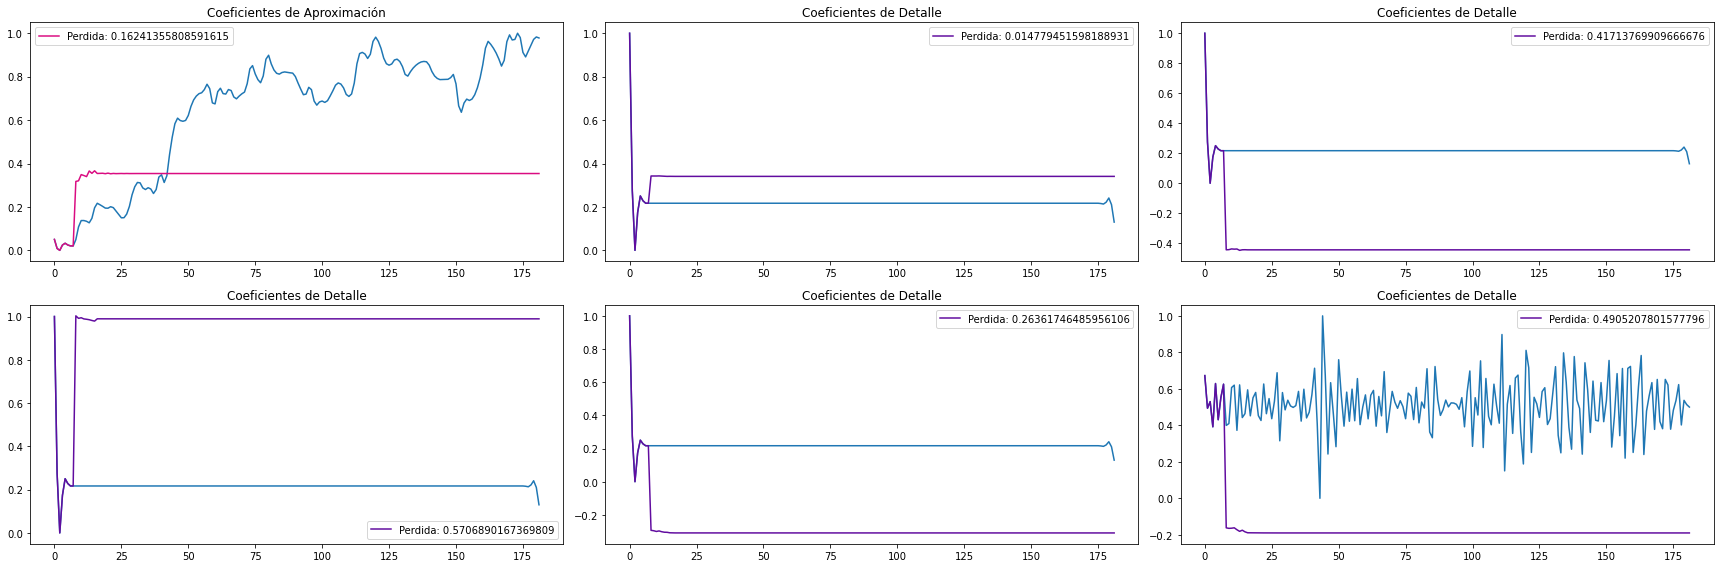

Perdidas predictivas: [tensor(0.1624, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0148, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.4171, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.5707, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.2636, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.4905, dtype=torch.float64, grad_fn=<MseLossBackward0>)]


In [19]:
perdidas_predictivas = []
plt.figure(figsize=(24, 8))

aprox_coef = True
index = 1
predicciones = []

for _ in range(len(components_e_n)):
    predicciones.append(utls.genera_prediccion_predictiva(entrenamiento_8_1[_][0][:8],8,len(entrenamiento_8_1[_]),networks[_]))
    perdidas_predictivas.append(criterion(predicciones[_], torch.tensor(components_e_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(range(len(components_e_n[_])), components_e_n[_])
    plt.plot(range(len(components_e_n[_])), predicciones[_].detach().numpy(),  label = f"Perdida: {float(perdidas_predictivas[_])}", color='#DA0C81' if aprox_coef else '#610C9F')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

print("Perdidas predictivas: " + str(perdidas_predictivas))

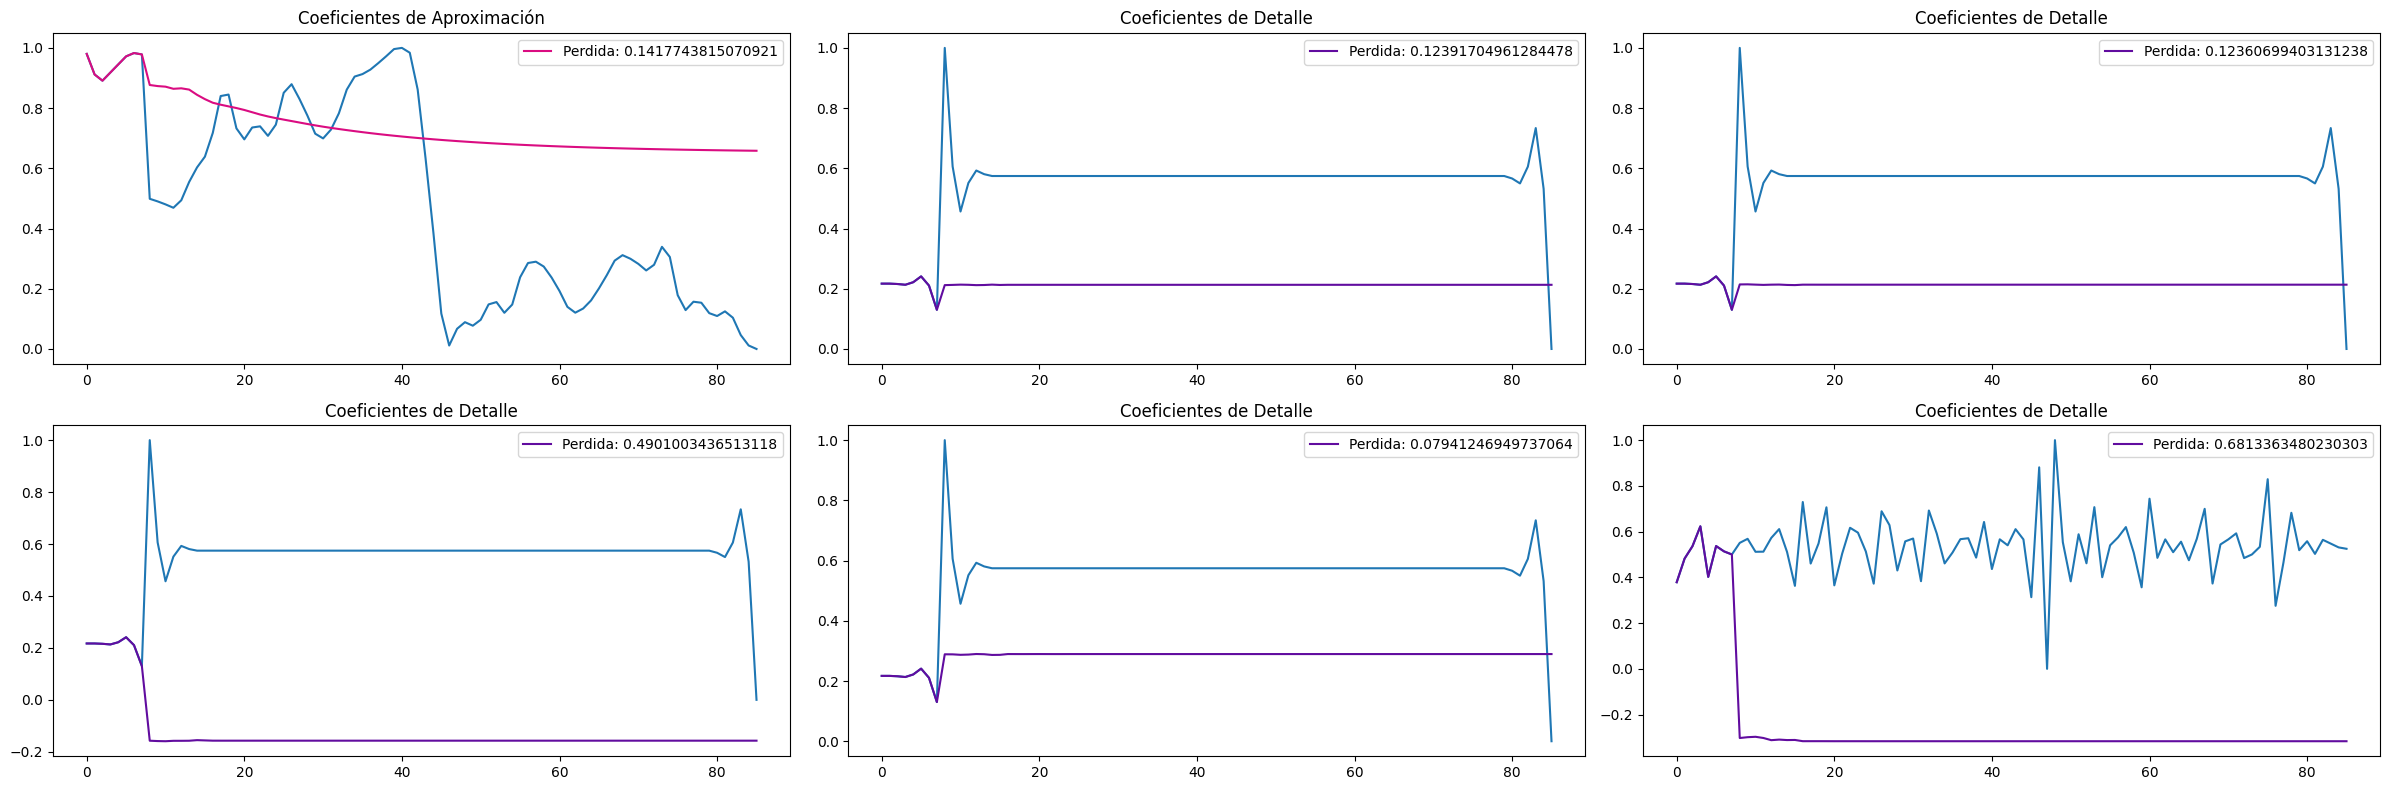

Perdidas predictivas: [tensor(0.1418, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.1239, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.1236, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.4901, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0794, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.6813, dtype=torch.float64, grad_fn=<MseLossBackward0>)]


In [ ]:
perdidas_predictivas = []
plt.figure(figsize=(24, 8))

aprox_coef = True
index = 1
predicciones = []

for _ in range(len(components_p_n)):
    predicciones.append(utls.genera_prediccion_predictiva(prueba_8_1[_][0][:8],8,len(prueba_8_1[_]),networks[_]))
    perdidas_predictivas.append(criterion(predicciones[_], torch.tensor(components_p_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(components_p_n[_])
    plt.plot(predicciones[_].detach().numpy(),  label = f"Perdida: {float(perdidas_predictivas[_])}", color='#DA0C81' if aprox_coef else '#610C9F')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

print("Perdidas predictivas: " + str(perdidas_predictivas))

#Reconstruimos la señal original usadno el conjunto de prueba

In [ ]:
for i in range(len(predicciones)):
    predicciones[i] = predicciones[i][8:]
print(predicciones[0])

#components_p_n = [utls.normalizar(vect) for vect in components_p]
predicciones_d = [utls.desnormalizar(vect.detach().numpy(),np.max(components_p[0]),np.min(components_p[0])) for vect in predicciones]
# D5_p = [utls.desnormalizar(vect) for vect in predicciones[1].detach().numpy()]
# D4_p = [utls.desnormalizar(vect) for vect in predicciones[2].detach().numpy()]
# D3_p = [utls.desnormalizar(vect) for vect in predicciones[3].detach().numpy()]
# D2_p = [utls.desnormalizar(vect) for vect in predicciones[4].detach().numpy()]
# D1_p = [utls.desnormalizar(vect) for vect in predicciones[5].detach().numpy()]


tensor([0.8768, 0.8732, 0.8712, 0.8641, 0.8657, 0.8615, 0.8441, 0.8298, 0.8178,
        0.8113, 0.8058, 0.8002, 0.7938, 0.7863, 0.7787, 0.7723, 0.7667, 0.7618,
        0.7570, 0.7521, 0.7473, 0.7426, 0.7383, 0.7343, 0.7305, 0.7269, 0.7234,
        0.7201, 0.7169, 0.7138, 0.7110, 0.7082, 0.7056, 0.7032, 0.7008, 0.6985,
        0.6963, 0.6943, 0.6923, 0.6905, 0.6887, 0.6870, 0.6854, 0.6838, 0.6823,
        0.6809, 0.6796, 0.6783, 0.6771, 0.6759, 0.6748, 0.6738, 0.6727, 0.6718,
        0.6709, 0.6700, 0.6692, 0.6684, 0.6676, 0.6669, 0.6662, 0.6655, 0.6649,
        0.6643, 0.6637, 0.6632, 0.6627, 0.6622, 0.6617, 0.6612, 0.6608, 0.6604,
        0.6600, 0.6596, 0.6593, 0.6589, 0.6586, 0.6583],
       grad_fn=<SliceBackward0>)


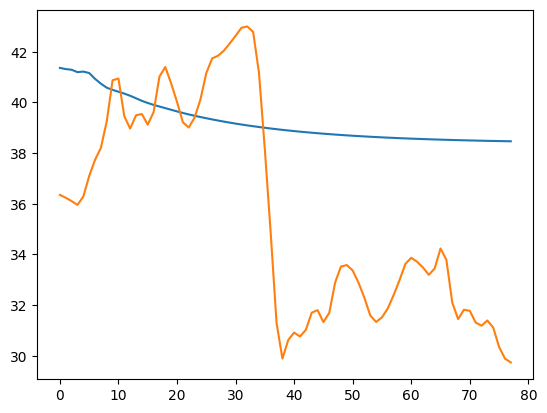

In [ ]:
plt.plot(predicciones_d[0])
plt.plot(components_p[0])
plt.show()

In [ ]:
# cA_p = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(coeffs_n_prueba_8_1[0],red_A1,8).detach().numpy()]
# cD_1_p = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(coeffs_n_prueba_8_1[1],red_D1,8).detach().numpy()]
# cD_2_p = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(coeffs_n_prueba_8_1[2],red_D2,8).detach().numpy()]
# cD_3_p = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(coeffs_n_prueba_8_1[3],red_D3,8).detach().numpy()]
# cD_4_p = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(coeffs_n_prueba_8_1[4],red_D4,8).detach().numpy()]
# cD_5_p = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(coeffs_n_prueba_8_1[5],red_D5,8).detach().numpy()]

# cA_p1 = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(prueba_8_1[0],red_A1,8).detach().numpy()]
# cD_1_p1 = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(prueba_8_1[1],red_D1,8).detach().numpy()]
# cD_2_p1 = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(prueba_8_1[2],red_D2,8).detach().numpy()]
# cD_3_p1 = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(prueba_8_1[3],red_D3,8).detach().numpy()]
# cD_4_p1 = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(prueba_8_1[4],red_D4,8).detach().numpy()]
# cD_5_p1 = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(prueba_8_1[5],red_D5,8).detach().numpy()]


78
78
78
78
78
78


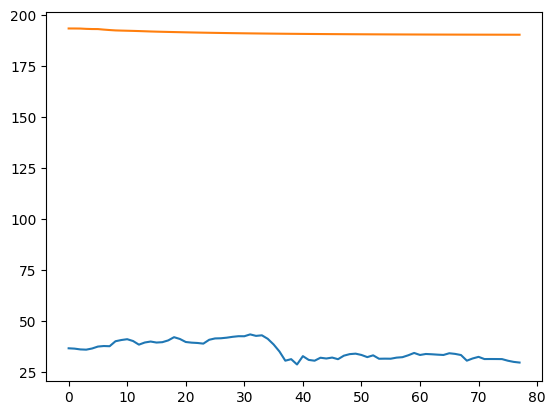

In [ ]:
#plt.plot(range(108), [utls.desnormalizar(vect) for vect in utls.genera_prediccion(pruebas_ordenadas[0],red_A1).detach().numpy().tolist()[0]])
# Mostrar el gráfico
#plt.show()

#coeffs_pp = [np.array(c) for c in [cA,cD_1,cD_2,cD_3,cD_4,cD_5]]
#coeffs_pp = [np.array(c) for c in [A5_p,D5_p,D4_p,D3_p,D2_p,D1_p]]
# #print([len(i) for i in coeffs])
# #print([len(i) for i in coeffs_p])

# # for i, c in enumerate(coeffs_prueba):
# #     print(f'Forma de c{i}: {np.shape(c)}')
# for i, c in enumerate(coeffs_n_prueba_8_1):
#     print(f'Forma de c{i}: {np.shape(c)}')
# for i, c in enumerate(prueba_8_1):
#     print(f'Forma de c{i}: {np.shape(c)}')
#rec = pywt.waverec(coeffs_pp, 'bior3.5', mode=mode)
for i in predicciones_d:
    print(len(i))
(A5_rec, D5_rec, D4_rec, D3_rec, D2_rec, D1_rec) = predicciones_d
# c_prueba = cierre[int(len(cierre) * 0.7):]
rec = A5_rec + D5_rec + D4_rec + D3_rec + D2_rec + D1_rec
plt.plot(range(len(cierre_p)),cierre_p) #Señal original
plt.plot(range(len(rec)),rec) #Señal predicha

# #plt.plot(range(len(cA)),cA)
plt.show()